In [6]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba
import torch
parent_path='/home/baly/projects/sliced_opt'
os.chdir(parent_path)
from sopt.library import *
from sopt.lib_ot import *   
import pot1d 


In [7]:
#test1
Lambda_list=np.array([10.0,100.0]).astype(np.float32)
time_pot_list=[]
time_lp_list=[[],[]]
time_new_list=[[],[]]
time_new_C_list=[[],[]]
time_sinkhorn_list=[[],[]]
#time5_list=[]

start_n=1500
end_n=10000
device='cpu'
step=500
k=3
print('start')

for n in range (start_n,end_n,step):
    m=n+1000
    print('n',n)
    print('m',m)
    time_pot=0
    time_lp=np.zeros(2)
    time_new=np.zeros(2)
    time_new_C=np.zeros(2)
    time_sinkhorn=np.zeros(2)
    mu=np.ones(n,dtype=np.float32)
    nu=np.ones(m,dtype=np.float32)

    for i in range (k):
        X=np.random.uniform(-20,20,n).astype(np.float32)
        Y=np.random.uniform(-40,40,m).astype(np.float32)
        X1=X.copy()
        Y1=Y.copy()
        start_time = time.time()
        X1.sort()
        Y1.sort()
        M=cost_matrix(X1,Y1)
        cost1,L1=pot_32(M)
        end_time = time.time()
        time_pot+=end_time-start_time
        #print('pot done')
        for j in range(len(Lambda_list)):
            Lambda=Lambda_list[j]             
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()       
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt_32(M,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new[j]+=end_time-start_time
            #print('ours numba done')
            
            
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()       
            #M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=pot1d.solve(X1,Y1,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new_C[j]+=end_time-start_time
            #print('ours C++ done')
            
    
            
            numItermax=int(200*n*np.log(n))
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            M=cost_matrix(X1,Y1)
            cost,gamma=opt_lp(mu,nu,M,Lambda,numItermax)
            end_time = time.time()
            time_lp[j]+=end_time-start_time
            #print('LP done')
            


            X1=X.copy()
            Y1=Y.copy()
            reg=np.float32(max(Lambda/40,0.1))
            numItermax=int(200*n*np.log(n))
            start_time=time.time()
            M=cost_matrix(X1,Y1)
            sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
            end_time = time.time()
            time_sinkhorn[j]+=end_time-start_time
            #print('Sinkhorn done')
    
    
    time_pot_list.append(time_pot/k)
    for j in range(2):
        time_lp_list[j].append(time_lp[j]/k)
        time_new_list[j].append(time_new[j]/k)
        time_new_C_list[j].append(time_new_C[j]/k)
        time_sinkhorn_list[j].append(time_sinkhorn[j]/k)
    #print(time_sinkhorn_list[j][-1]) 

time_list={}
time_list['pot']=time_pot_list
time_list['lp']=time_lp_list 
time_list['new']=time_new_list
time_list['new_C']=time_new_C_list
time_list['sinkhorn']=time_sinkhorn_list


torch.save(time_list,'experiment/performance_test/results/time_list_numba.pt')

start
n 1500
m 2500
n 2000
m 3000
n 2500
m 3500
n 3000
m 4000
n 3500
m 4500
n 4000
m 5000
n 4500
m 5500
n 5000
m 6000
n 5500
m 6500
n 6000
m 7000
n 6500
m 7500
n 7000
m 8000
n 7500
m 8500
n 8000
m 9000
n 8500
m 9500
n 9000
m 10000
n 9500
m 10500


17


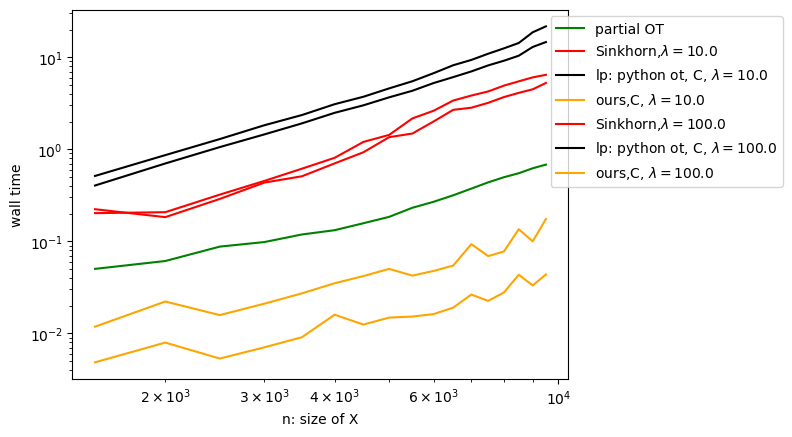

In [22]:

time_list=torch.load('experiment/performance_test/results/time_list_numba.pt')
time_pot_list=time_list['pot']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_new_C_list=time_list['new_C']
time_sinkhorn_list=time_list['sinkhorn']
print(len(time_pot_list))
# start_n=1500
# end_n=10000
# device='cpu'
# step=500
# k=10

start_n=1500
end_n=10000
step=500
k=2

n_list=range(start_n,end_n,step)
             
fig = plt.figure()
ax = plt.subplot(111)

ax.loglog(n_list,time_pot_list[:],'green',label='partial OT')
for j in range(2):
    ax.loglog(n_list,time_sinkhorn_list[j],'red',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    ax.loglog(n_list,time_lp_list[j],'black',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    #ax.loglog(n_list,time_new_list[j],'red',label='ours, $\lambda=$'+str(Lambda_list[j]))
    ax.loglog(n_list,time_new_C_list[j],'orange',label='ours,C, $\lambda=$'+str(Lambda_list[j]))
#box = ax.get_position()
ax.legend(bbox_to_anchor=(0.95,1.0))
#ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
#ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.23),
       #   fancybox=True, shadow=True, ncol=3)
ax.set_xlabel('n: size of X')
ax.set_ylabel("wall time")
plt.savefig('experiment/reviewer/result/time_log.pdf',format='pdf',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [33]:
A=np.log(time_lp_list[1])
N=len(A)
A_diff=np.zeros(N-1)
for i in range(N-1):
    A_diff=(A[i+1]-A[i])/np.log(n_list[i+1]/n_list[i])
print('slop if LP is', A_diff.mean())
    

slop if LP is 2.7493329118692924


In [5]:
time_pot_list

[0.03701620101928711, 0.06229724884033203, 0.09386627674102783]

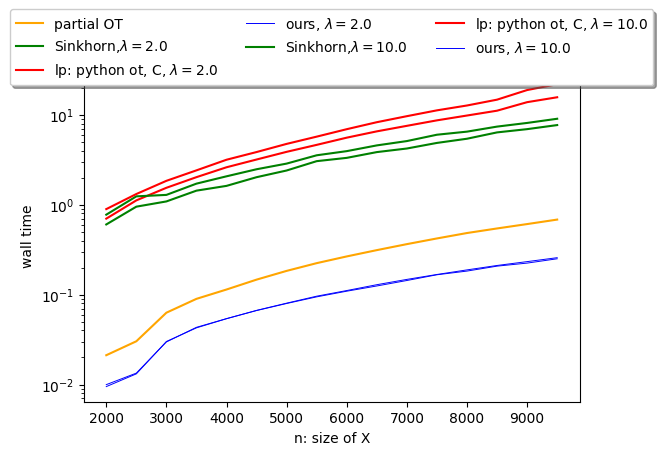

In [34]:
start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)
time_list=torch.load('experiment/test/results/time_list_numba.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']


plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.20),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_uniform_32.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [16]:
@nb.njit(['(float64[:])(float64[:],float64[:],int64)'],fastmath=True)
def Gaussian_mixture(mu_list, variance_list,n):
    N=mu_list.shape[0]
    indices=np.random.randint(0,N,n)
    X=np.zeros(n)
    for i in range(n):
        X[i]=np.random.normal(mu_list[indices[i]],variance_list[indices[i]])
    return X

# @nb.njit(['(float32[:])(float32[:],float32[:],int64)'],fastmath=True)
# def Gaussian_mixture_32(mu_list, variance_list,n):
#     N=mu_list.shape[0]
#     indices=np.random.randint(0,N,n)
#     X=np.zeros(n,dtype=np.float32)
#     for i in range(n):
#         X[i]=np.float32(np.random.normal(mu_list[indices[i]],variance_list[indices[i]]))
#     return X


    
    

In [17]:
mu1=np.linspace(-4,4,5)
mu2=np.linspace(-5,5,6)
var1=np.ones(5)
var2=np.ones(6)
X=Gaussian_mixture(mu1,var1,10)
print(X)

[ 5.43949762 -0.95486728  1.48640772 -0.21362046 -0.00693473 -1.63088248
  2.24904571  6.23082783 -1.03992554  0.27571546]


start
n 1500
m 2500
<class 'numpy.float32'>
0.09961049556732178
n 2000
m 3000
<class 'numpy.float32'>
0.18713085651397704
n 2500
m 3500
<class 'numpy.float32'>
0.3486999750137329
n 3000
m 4000
<class 'numpy.float32'>
0.5792428255081177
n 3500
m 4500
<class 'numpy.float32'>
0.9303261280059815
n 4000
m 5000
<class 'numpy.float32'>
1.9088943958282472
n 4500
m 5500
<class 'numpy.float32'>
3.769697976112366
n 5000
m 6000
<class 'numpy.float32'>
10.101075983047485
n 5500
m 6500
<class 'numpy.float32'>
14.35975148677826
n 6000
m 7000
<class 'numpy.float32'>
20.929134917259216
n 6500
m 7500
<class 'numpy.float32'>
28.872381186485292
n 7000
m 8000
<class 'numpy.float32'>
33.99246287345886
n 7500
m 8500
<class 'numpy.float32'>
31.113644123077393
n 8000
m 9000
<class 'numpy.float32'>
35.172746539115906
n 8500
m 9500
<class 'numpy.float32'>
35.926887679100034
n 9000
m 10000
<class 'numpy.float32'>
30.91623110771179
n 9500
m 10500
<class 'numpy.float32'>
30.274378991127016


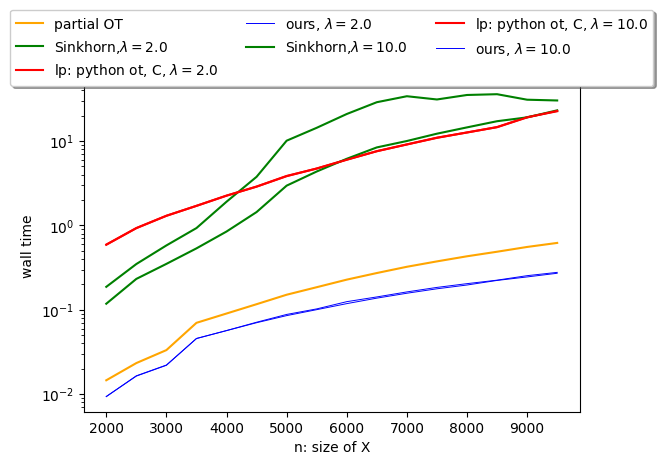

In [39]:
#test2
mean1=np.linspace(-4,4,5)
mean2=np.linspace(-5,5,6)
var1=np.ones(5)
var2=np.ones(6)
#Lambda=60
Lambda_list=np.array([2.0,10.0]).astype(np.float32)
time_pot_list=[]
time_v2_list=[[],[]]
time_v2_a_list=[[],[]]
time_lp_list=[[],[]]
time_new_list=[[],[]]
time_sinkhorn_list=[[],[]]
#time5_list=[]

start_n=1500
end_n=10000
device='cpu'
step=500
k=5
print('start')

for n in range (start_n,end_n,step):
    m=n+1000
    print('n',n)
    print('m',m)
    time_pot=0
    time_v2=np.zeros(2)
    time_v2_a=np.zeros(2)
    time_lp=np.zeros(2)
    time_new=np.zeros(2)
    time_sinkhorn=np.zeros(2)
    mu=np.ones(n,dtype=np.float32)
    nu=np.ones(m,dtype=np.float32)

    for i in range (k):
        X=Gaussian_mixture(mean1,var1,n).astype(np.float32) #np.random.uniform(-20,20,n).astype(np.float32)
        Y=Gaussian_mixture(mean2,var2,m).astype(np.float32) #np.random.uniform(-40,40,m).astype(np.float32)
        X1=X.copy()
        Y1=Y.copy()
        start_time = time.time()
        X1.sort()
        Y1.sort()        
        cost1,L1=pot_32(X1,Y1)
        end_time = time.time()
        time_pot+=end_time-start_time

        for j in range(len(Lambda_list)):
            Lambda=Lambda_list[j]
            
            
#            start_time = time.time()

#             X1.sort()
#             Y1.sort()       
#             opt_1d_v2(X1,Y1,Lambda)
#             end_time = time.time()
#             time_v2[j]+=end_time-start_time
            
#             X1=X.copy()
#             Y1=Y.copy()
#             start_time = time.time()
# #            M=cost_matrix(X1,Y1)
#             X1.sort()
#             Y1.sort()
#             opt_1d_v2_a(X1,Y1,Lambda)
    
             
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()       
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt_32(M,Lambda) #,verbose=False,plots=False)
            #L_new=getPiFromRow(n,m,piRow)
            end_time = time.time()
            time_new[j]+=end_time-start_time
    
            
    #        Y1=Y[0:n]
            numItermax=int(200000*n/1000)
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            cost,gamma=opt_lp(X1,Y1,Lambda,numItermax)
            end_time = time.time()
            time_lp[j]+=end_time-start_time
            

            X1=X.copy()
            Y1=Y.copy()
            numItermax=int(100*n)
#            print(mu.dtype)
            reg=np.float32(max(Lambda/10,0.1))
            start_time=time.time()
            M=cost_matrix(X1,Y1)
            sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
            end_time = time.time()
            time_sinkhorn[j]+=end_time-start_time
              
    
    
    time_pot_list.append(time_pot/k)
    for j in range(2):
        time_v2_list[j].append(time_v2[j]/k)
        time_v2_a_list[j].append(time_v2_a[j]/k)
        time_lp_list[j].append(time_lp[j]/k)
        time_new_list[j].append(time_new[j]/k)
        time_sinkhorn_list[j].append(time_sinkhorn[j]/k)
    #print(type(reg))
    print(time_sinkhorn_list[0][-1]) 

time_list={}
time_list['pot']=time_pot_list
time_list['v2']=time_v2_list
time_list['v2_a']=time_v2_a_list
time_list['lp']=time_lp_list 
time_list['new']=time_new_list
time_list['sinkhorn']=time_sinkhorn_list

torch.save(time_list,'experiment/test/results/time_list_numba_gaussian.pt')

time_list=torch.load('experiment/test/results/time_list_numba_gaussian.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.23),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_numba.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [37]:
time_sinkhorn_list

[[0.1151350975036621,
  0.21945080757141114,
  0.4094530582427979,
  1.0383500576019287,
  1.9707772731781006,
  3.0151814460754394,
  5.923446941375732,
  14.621810913085938,
  27.42362961769104,
  37.30857934951782,
  29.938614892959595,
  27.163487720489503,
  19.23037395477295,
  17.647161769866944,
  22.659733724594116,
  22.345075798034667,
  21.921456384658814],
 [0.08024487495422364,
  0.15455927848815917,
  0.27326092720031736,
  0.4823433876037598,
  0.8247636318206787,
  1.1099267482757569,
  2.0573440551757813,
  4.082003402709961,
  7.284257459640503,
  9.868714141845704,
  12.999133491516114,
  16.27747497558594,
  19.23168902397156,
  22.64235725402832,
  26.595413494110108,
  29.34384951591492,
  35.1268087387085]]

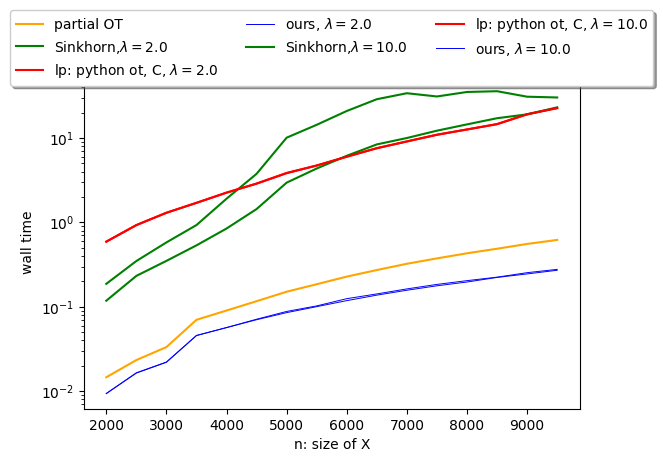

In [43]:
time_list=torch.load('experiment/test/results/time_list_numba_gaussian.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.22),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_gaussian_32.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [21]:
reg=max(Lambda/40,0.1)
start_time=time.time()
M=cost_matrix(X1,Y1)

print(mu.dtype)
print(nu.dtype)
print(M.dtype)
print(type(Lambda))
reg=np.float32(max(Lambda/40,0.1))

print(type(reg))
#sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
end_time = time.time()



float32
float32
float32
<class 'numpy.float32'>
0.1
<class 'numpy.float32'>


In [34]:
mu = np.array([.1, .2])
nu =np.array([.1, .1])
M = np.array([[0., 1.], [2., 3.]])
mass=0.1
reg=1.0
K=entropic_opt(mu,nu,M,mass,reg,1000000)
print(K)

[[0.06439143 0.02368828]
 [0.00871443 0.00320586]]


In [35]:
start=time.time()
for k in range(10):
#    A=np.random.rand(5000,3)
    B=np.random.rand(10000,3)
end=time.time()
print(end-start)
print('hello')

0.003829479217529297
hello


In [ ]:
start=time.time()
for k in range(10):
    A=np.random.rand(5000,3)
    B=np.random.rand(10000,3)
    cost_matrix_d(A,B)
end=time.time()
print(end-start)

In [64]:
@nb.njit(['float32[:,:](float32[:,:],float32[:,:])'],fastmath=True)
def cost_matrix_d_321(X,Y):
    '''
    input: 
        X: (n,) float np array
        Y: (m,) float np array
    output:
        M: n*m matrix, M_ij=c(X_i,Y_j) where c is defined by cost_function.
    
    '''
    n,d=X.shape
    m=Y.shape[0]
    M=np.empty((n,m),dtype=np.float32) 
    for i in range(n):
        M[i]=np.sum(cost_function(X[i],Y),1)
    return M

In [65]:

start=time.time()
for i in range(10):
    X=np.random.rand(10000,3).astype(np.float32)
    Y=np.random.rand(12000,3).astype(np.float32)
    M1=cost_matrix_d_321(X,Y)
end=time.time()
print(end-start)

7.603938817977905


In [66]:
start=time.time()
for i in range(10):
    X=np.random.rand(10000,3).astype(np.float32)
    Y=np.random.rand(12000,3).astype(np.float32)
    M1=cost_matrix_d_32(X,Y)
end=time.time()
print(end-start)

11.36817717552185
